## About
This document aims to explain the crossover detection pipeline from the raw samples to the visual output.

## Assembling the Reference
The core hypothesis of this project relies on alignment to dual genome. Better make it first.
1. **Change fasta file headers.** Determines the chromosome notation used downstream. Use distinct names, and make sure one isn't included in the other (**not** `genome`, `genome2`)
    ```bash
     awk '/^>/{print ">alpha" ++i; next}{print}' < genomeA.fasta
     awk '/^>/{print ">beta" ++i; next}{print}' < genomeB.fasta
     ```
2. **Concatenate reference files.** This is the reference all samples are mapped to.
    ```bash
    cat genomeA.fasta genomeB.fasta > genomeAB.fasta
    ```
3. **Generate genome sizes.** Used to generate bins. `cat AB_sizes.genome` to verify the sizes make sense.
    ```bash
    # module load samtools-gnu 
    samtools faidx genomeAB.fasta
    cut -f1,2 genomeAB.fasta.fai > AB_sizes.genome # notice input is .fai here
    ```
4. **Index new reference.** Required for BWA alignment.
    ```bash
    # module load bwa-gnu
    bwa index genomeAB.fasta
    ```

### Create bin template
Notice `[X]` refers to an array (multiple files)
5. **Map source alignments and filter.** Using `BWA mem`, map each paired reads `[genomeA_R1_00X.fastq.gz]`, `[genomeB_R2_00X.fastq.gz]` to `genomeAB.fasta` (`-t 5` is the amount of parallel threads, it does not alter the alignment result). Pipe the output to samtools in order to filter reads with quality / Fred score < 30 and convert to BAM format (binary / smaller form of SAM).
    ```bash
    # module load bwa-gnu samtools-gnu
    for R1 in genomeA_control_L001_00*R1.fastq.gz; 
    do
        bwa mem -t 5 references/genomeAB.fasta $R1 $R2 | samtools view -Sbh -q 30 - > `$`R1.bam
    done```
4. **Merge and sort** all alignment files of the same library.
    ```bash
    samtools merge genomeA_control_L001_001.bam [genomeA_..._002.bam genomeA_..._003.bam ...] > genomeA_control_L001_merged.bam
    samtools sort genomeA_control_L001_merged.bam > genomeA_control_L001_merged.sorted.bam
   ```
6. **Deduplicate** in order to retain unique reads
    ```bash
    # module load jdk picard
    picard MarkDuplicates I=genomeA_control_L001_merged.sorted.bam O=genomeA_control_L001_merged.sorted.dedup.bam M=genomeA_control_L001_merged.dedup_metrics.txt REMOVE_DUPLICATES=true
    ```
7. **Create bins table** (decide on bin size, step size) using `make_bins.py` (previewed below)
    ```bash
    bedtools coverage -counts -sorted -a TAIR_sizes.bins.txt -b Col2_ATGTT_L001.q30.sorted.dedup.bam > Col2_ATGTT_L001.q30.sorted.dedup.cov.bedgraph
    ```
8. **Filter uninformative bins** using `filter_genomes.py`.
9. **Calculate average bin coverage**. In our example, Col avg = 3.53, Ler avg = 5.21
    ```bash
    cat sample.cov-200-200.bedgraph | awk '{sum+=$4} END { print "Average = ",sum/NR}'
    ```


In [ ]:
# %load make_bins.py
import argparse
import pandas as pd

parser = argparse.ArgumentParser(description='Splits the genome into equal sized bins to be used with bedtools.')
parser.add_argument('reference', type=str, help='Reference genome sizes file.')
parser.add_argument('binSize', type=int, help='Size of each bin.')
parser.add_argument('binStep', type=int, default=0, nargs='?',
    help='Step size between bins. Defaults to bin size.')
args = parser.parse_args()
if args.binStep == 0:
    args.binStep = args.binSize

genome_sizes = pd.read_csv(args.reference, sep='\t', index_col=0, names=['chrm', 'size'])
chrm_bins_df = []

print(f'Creating bins for "{args.reference}" with binSize={args.binSize} and binStep={args.binStep}.')

# iterate over chromosomes
for chrm, row in genome_sizes.iterrows():
    start = pd.np.arange(1, row['size'], args.binStep)
    end = start + args.binSize
    name = pd.np.full(len(start), chrm)
    # shape positions as dataframe
    data = {'chr': name, 'start': start, 'end': end}
    df = pd.DataFrame(data)
    chrm_bins_df.append(df)

bin_table = pd.concat(chrm_bins_df)
if args.binStep == args.binSize:
    name_out = f'{args.reference}.bins-{args.binSize}.txt'
else:
    name_out = f'{args.reference}.bins-{args.binSize}-{args.binStep}.txt'
try:
    bin_table.to_csv(name_out, sep='\t', index=False)
    print(f'Done. Bin table written to "{name_out}".')
except Exception as ex:
    print(f'Failed to write results to "{name_out}". Please check the directory exists and has suitable permissions.\n{ex}')

In [ ]:
# %load filter_genomes.py
import argparse
import pandas as pd

parser = argparse.ArgumentParser(description='Creates an informative bin template based on coverage A and B as produced by bedtools.')
parser.add_argument('coverageA', type=str, help='Coverage bedgraph of control parent A.')
parser.add_argument('coverageB', type=str, help='Coverage bedgraph of control parent B.')
parser.add_argument('outFile', type=str, help='Filename to output the resulting template to.')
args = parser.parse_args()


print(f'Creating bin template using "{args.coverageA}" and "{args.coverageB}".')

genome_a = pd.read_csv(args.coverageA, sep='\t', names=['chrm', 'start', 'end', 'val'])
genome_b = pd.read_csv(args.coverageB, sep='\t', names=['chrm', 'start', 'end', 'val'])

genome_names = genome_a.chrm.str.replace(r'\d', '', regex=True).unique()
# Make sure the names are in the correct order
if genome_a[genome_a['chrm'].str.startswith(genome_names[0])].val.mean() < genome_a[~genome_a['chrm'].str.startswith(genome_names[0])].val.mean():
    genome_names = genome_names[::-1]

genome_reads = genome_a.merge(genome_b, on=['chrm','start','end'], suffixes=(genome_names[0], genome_names[1]))

length = genome_reads.iloc[0, 2] - genome_reads.iloc[0, 1]
step = genome_reads.iloc[1, 1] - genome_reads.iloc[0, 1]

for s in genome_names:
    source_bins = genome_reads.index[genome_reads.chrm.str.startswith(s)]
    informative_map = genome_reads.loc[source_bins, 'val' + s] != 0
    unique_map = genome_reads.loc[source_bins, 'val' + s] == genome_reads.iloc[source_bins, 3:].sum(axis=1)
    genome_reads.loc[source_bins, 'keep'] = informative_map & unique_map

keep = genome_reads.keep.sum() * 100 / genome_reads.keep.count()
print('{0:.2f}% bins kept past filtering.'.format(keep))

genome_template = genome_reads[genome_reads.keep].iloc[:, :3]

try:
    genome_template.to_csv(args.outFile, sep='\t', index=False, header=False)
    print(f'Done. Template written to "{args.outFile}".')
except Exception as ex:
    print(f'Failed to write results to "{args.outFile}". Please check the directory exists and has suitable permissions.\n{ex}')



### Prepare dataset
Steps 4-6 can be mass excecuted using the attached scripts `fastq_to_hmm.sh` and `dirs_process.sh` by commenting out (adding # before) the last two lines 
9. Map sample reads to concatenated reference `genomeAB.fasta`
10. Quality filter and sort
11. Remove duplicates
12. Get coverage over bin template using bedtools

```bash
r2=${1/_1/_2}
fname=${1/_1.fastq.gz/}                                                                                                                       
ref="references/genomeAB.fasta"

bwa mem -t 5 $ref $1 $r2 | samtools view -Sbh -F 1284 -q 20 - | samtools sort - -o $fname.q30.sorted.bam
samtools index $fname.q30.sorted.bam                                                                                  
bin_template="/home/labs/alevy/zisserh/datasets/shay/crossover_detection/bin_template_pos.bed"
picard MarkDuplicates I=$fname.q30.sorted.bam O=$fname.q30.sorted.dedup.bam M=$fname.dup_metrics.txt REMOVE_DUPLICATES=true
bedtools coverage -counts -sorted -a "$bin_template" -b $fname.q30.sorted.dedup.bam > $fname.dedup.cov.bedgraph
```

## Using the module
There are multiple python dependencies required in order for the module `hmm_analysis.py` (wip name) to run. The recommended way to set up a suitable environment is by using [Anaconda3](https://www.anaconda.com/distribution/).
```bash
module load anaconda # for servers that use "module" imports such as wexac
conda env create -f hmm_env.yml # creates a virtual environment
conda activate xoe # activate it
python xover_script.py my_sample.dedup.cov.bedgraph # running the "default" pipeline on file "my_sample"
```
For advanced users who would rather use their own environments, the dependencies are listed below. Later versions of the packages are likely to work, but were not tested.
```
  - python=3.6.*                                                                                                   
  - pandas=0.24.*
  - matplotlib
  - hmmlearn
```
- Works well indepedant of coverage (avg < 1) ERR2377152

## Training a model

# Module Documentation

class `CrossoverDetector`: represents a single data sample to be processed.  

`HMM`: hidden markov model of type GaussianHMM imported from hmmlearn. When predicting CO positions it's recommended to use a previously trained model. Alternatively, a model can be trained from scratch.  
`crossovers`: matching reciprocal crossovers based on relative position in chromosome.  
**todo: add precise desc**  
`flags`: dictionary, contains the state of other processes.

#### Preprocess - averaging read count
Two methods: arbitrary (group every n points) and binned (group all in n sized bins).

Arbitrary - group every n points
* Bin size highly irregular
* Consistent distribution
* Identical across samples

#### Hidden Markov Model Training
By default the model will be initialized with 3 states - Homozygote A, Heterozygote, and Homozygote B. Each state is defined by mean, variance, and transition odds. During the fitting process these parameters are adjusted in a process called [Expectation-maximization](https://www.statisticshowto.datasciencecentral.com/em-algorithm-expectation-maximization/), or EM for short. It's recommended to train the model on multiple samples in order to produce more reliable results.

In [11]:
print('Approximate position offset:')
pd.Series({'min': 166.5, 'p25': 2364.25, 'p50': 6860.5, 'p75': 13613.5, 'max': 331572.5})

Approximate position offset:


min       166.50
p25      2364.25
p50      6860.50
p75     13613.50
max    331572.50
dtype: float64

## Statistics
Useful commands which are not mandatory but provide useful insight.

### BAM files
- Read length: display most common read lengths of the first 10k reads.  
`samtools view testfile.bam | awk '{print length($10)}' | head -10000 | sort | uniq -c | sort -k1 -nr | head`

# Syri / Genome matching / Lift over

```bash
module load mummer
nucmer --maxmatch -c 100 -b 500 -l 50 refgenome qrygenome
delta-filter -m -i 90 -l 100 out.delta > out_m_i90_l100.delta
show-coords -THrd out_m_i90_l100.delta > out_m_i90_l100.coords
/home/labs/alevy/zisserh/apps/syri/syri/bin/syri -c out_m_i90_l100.coords -r TAIR10_filtered.fasta -q ../Denovo_Ler_Assembly/GCA_001651475.1_Ler_Assembly_genomic_filtered.fasta -d out_m_i90_l100.delta --nc 5
```
Source: [Syri Publication Additional File 2 Col-0-Ler](https://www.biorxiv.org/content/10.1101/546622v3.supplementary-material)  
https://www.biostars.org/p/49820/

[HMM Tutorial](https://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf)  
[Assembly match 3 Syri](https://schneebergerlab.github.io/syri/example.html)  
[HMM Ref paper "Rapid and Inexpensive..."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349092/#!po=28.1250)  
[Lift annotation Shay](https://genome.ucsc.edu/cgi-bin/hgLiftOver)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import coda


%load_ext autoreload
%autoreload 2

In [3]:
sample_files = {'default_revised': "collab/sample-E-MTAB-4657/ERR1432437.sorted.dedup.template-200-col-ler-7-11-19.bedgraph",
                'kiril_revised': '/home/labs/alevy/Collaboration/novaseq6_09_2019/demultiplexed_fastq/O/KirilsF2_2/KirilsF2_2_S2_.dedup.cov.bedgraph',
                'f1': "/home/labs/alevy/Collaboration/crossover_detection/F1_col_ler_merge/F1_artificial.q30.sorted.dedup.cov-200-200.bedgraph",
                'shay_lowcov': '~/datasets/shay/E-MTAB-6577/ERR2377152.q30.sorted.dedup.cov-200-200.bedgraph'}
def kiril_files(num):
    s = '/home/labs/alevy/Collaboration/novaseq6_09_2019/demultiplexed_fastq/O/KirilsF2_{}/KirilsF2_{}_S{}_.dedup.cov.bedgraph'
    return s.format(num, num, num)

In [5]:
sample1 = coda.CrossoverDetector(log_level=1)
sample1.preprocess(kiril_files(10), interval=10)
sample1.genome_hmm_detection(smooth_window_size=10, smooth_model='v1', hmm_pickle='res_hmm.pickle',
                             context='~/datasets/TAIR10/context.bed')

[2019-12-19 11:47:03.438, INFO] - Successfully loaded 'KirilsF2_10_S10_.dedup.cov.bedgraph'. Mean coverage is 5.996.
[2019-12-19 11:47:03.438, INFO] - Started genome_hmm_detection() on "KirilsF2_10_S10_.dedup.cov.bedgraph"
[2019-12-19 11:47:03.438, INFO] - Loading context table.
[2019-12-19 11:47:03.446, INFO] - Loading HMM from pickle "res_hmm.pickle".
[2019-12-19 11:47:03.447, INFO] - Predicting.
[2019-12-19 11:47:03.695, INFO] - Extractring suspect crossover positions.
[2019-12-19 11:47:03.719, INFO] - Smoothing via model v1.
[2019-12-19 11:47:03.868, INFO] - Re-exctracting crossover positions.
[2019-12-19 11:47:03.885, INFO] - Found 55 suspects.
[2019-12-19 11:47:03.887, INFO] - Looking for reciprocal crossover positions.
[2019-12-19 11:47:04.309, INFO] - 13 crossovers found, 2 more possible duplicate(s).
[2019-12-19 11:47:04.309, INFO] - Refining crossover locations.
[2019-12-19 11:47:05.028, INFO] - Done.


Text(0.5, 1.0, 'Pre Transformation Read Count Per Bin Distribution')

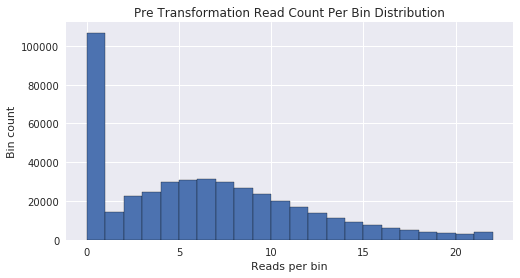

In [6]:
plt.figure(figsize=(8,4))
sample1._raw_sample.val.hist(bins=np.arange(sample1._raw_sample.val.max()), label='Read count')
plt.ylabel('Bin count')
plt.xlabel('Reads per bin')
plt.title('Pre Transformation Read Count Per Bin Distribution')

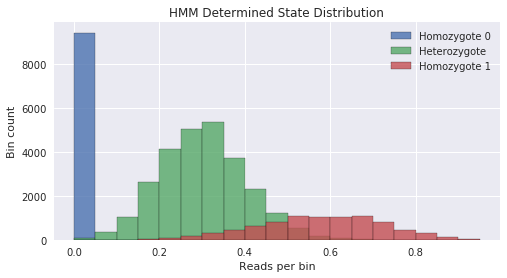

In [7]:
plt.figure(figsize=(8,4))
plt.ylabel('Bin count')
plt.xlabel('Reads per bin')
plt.title('HMM Determined State Distribution')

for pred, name in enumerate(['Homozygote 0', 'Heterozygote', 'Homozygote 1']):
    sample1._sample_predictions[sample1._sample_predictions.pred == pred].val.hist(bins=np.arange(0,1,0.05),
                                                                                   alpha=0.8, label=name)
plt.legend()

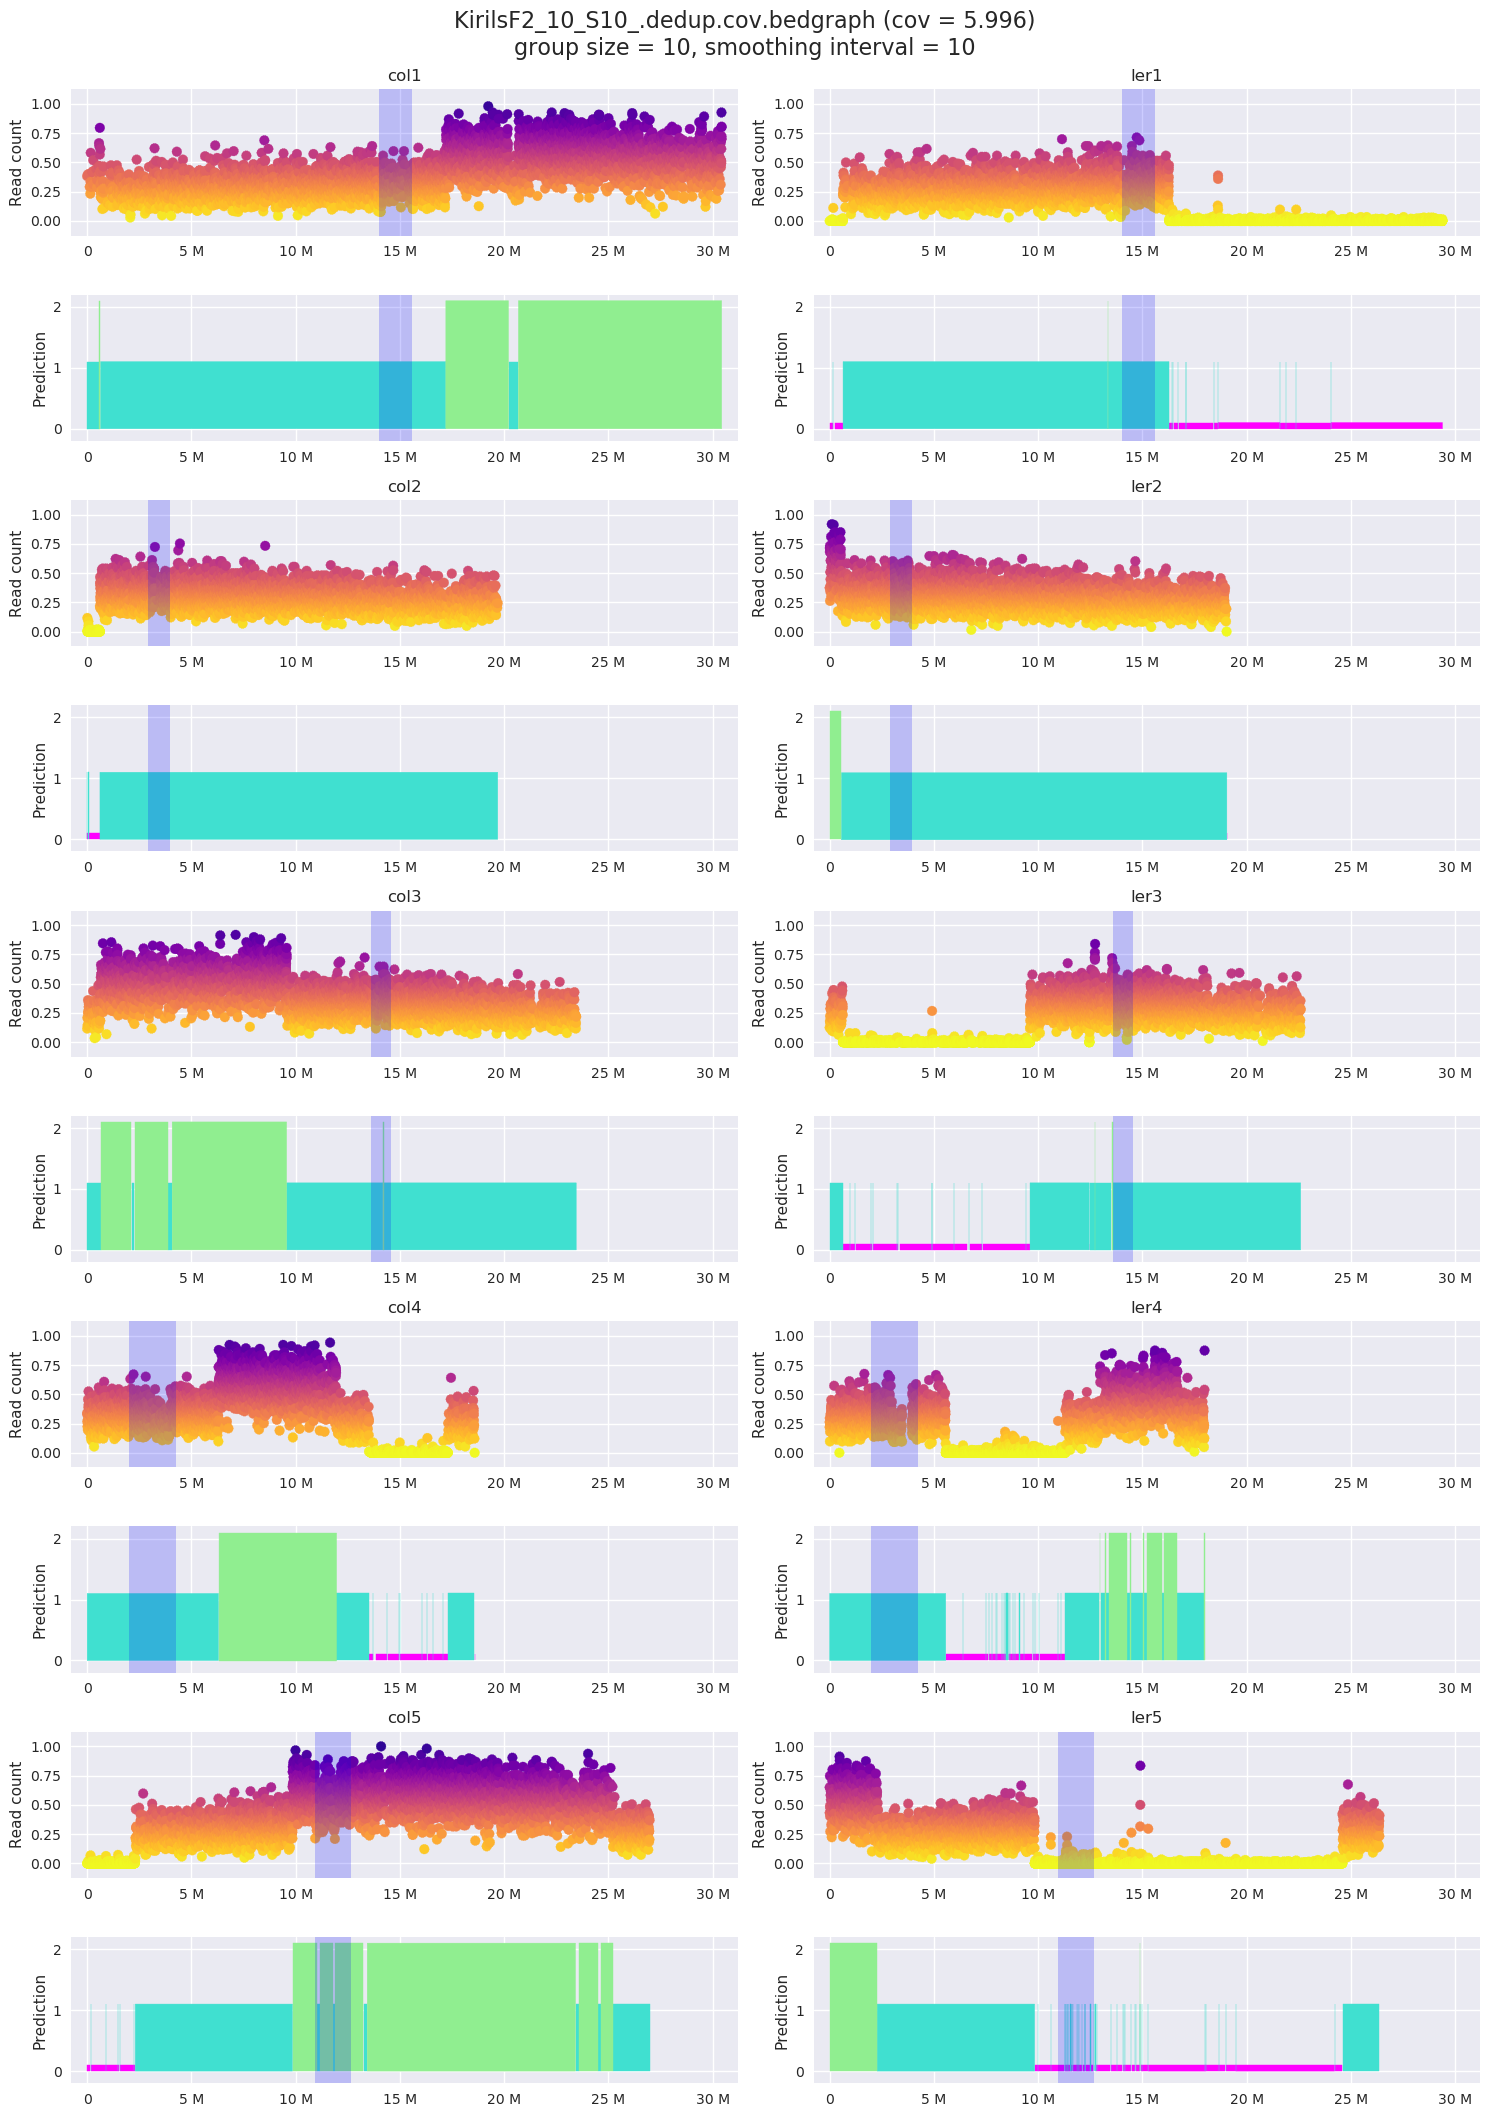

In [9]:
sample1.plot_hmm(pred_column='pred') #, to_fname=sample1._sample_name.replace('.bedgraph', '.png'))

In [10]:
sample1

CrossoverDetector(HMM = GaussianHMM(n_components = 3, trained_samples(6),
_avg_cov = 5.996,
_context_table(5),
_flags = {'is_loaded': True, 'is_fit': True, 'syri': False, 'cent_data': True},
_group_bin_itv = 10,
_raw_sample(446399),
_sample(44648),
_sample_name = KirilsF2_10_S10_.dedup.cov.bedgraph,
_sample_predictions(44648),
_smooth_window_size = 10,
crossovers(14),
log_level = 1,
scores(10),
sequences(10),
suspects(55))

## Experiments 

In [11]:
def get_source(suspect_idx):
    sus_bin = sample1._sample_predictions.iloc[suspect_idx-2:suspect_idx+2, :3]
    res =  sample1._raw_sample[(sample1._raw_sample.chrm == sus_bin.iloc[0].chrm) &
                               (sample1._raw_sample.start >= sus_bin.iloc[0].start) &
                               (sample1._raw_sample.end <= sus_bin.iloc[-1].end)]
    local_max = res.val.idxmax()
    print(sample1._raw_sample.loc[local_max])
    return res

In [12]:
shdema_results = pd.read_csv('Kiril_co_table.csv', usecols=[2, 3, 5, 6, 13])
shdema_results.rename(columns={'chr':'chrm'}, inplace=True)
shdema_results.dropna(how='all', inplace=True)
shdema_results = shdema_results

def res_shdema(n):
    return shdema_results[shdema_results.plant == 'kiril_F2_{}'.format(n)]

def shdema_diff(n, droplabels=False):
    df = res_shdema(n)
    co_copy = sample1.crossovers.copy()
    co_copy = co_copy.reset_index()
    merge = df.merge(co_copy, on=['chrm', 'updated', 'change'], how='outer', sort=True)
    merge['diff'] = (merge['average_snp_co'].astype(float) - merge['end']).abs()
    if droplabels:
        merge.drop(droplabels, inplace=True)
    print(merge['diff'].describe().round(1))
    merge = merge.sort_values(by=['index'])
    return merge.iloc[:, [i for i in range(15) if i not in [7, 8, 9]]]

In [15]:
shdema_diff(10, droplabels=[11, 12])

count       12.0
mean      5311.1
std       6362.0
min         81.0
25%        466.2
50%       2006.5
75%      11588.5
max      17248.0
Name: diff, dtype: float64


,plant,chrm,updated,change,average_snp_co,index,end,possible_dup,binsize,binsize_percentile,context,diff
1,kiril_F2_10,col1,2.0,1.0,641882,27,641801,False,6800,82.13,NaN,81.0
0,kiril_F2_10,col1,1.0,2.0,17198807,2848,17195801,False,4800,69.07,NaN,3006.0
2,kiril_F2_10,col2,0.0,1.0,618099,5247,617401,False,2200,20.47,NaN,698.0
3,kiril_F2_10,col3,1.0,2.0,636741,9003,650601,False,4000,61.29,NaN,13860.0
4,kiril_F2_10,col3,2.0,1.0,9567459,10160,9567001,False,2400,30.15,NaN,458.0
7,kiril_F2_10,col4,1.0,2.0,6304389,14799,6302001,False,4400,66.59,NaN,2388.0
8,kiril_F2_10,col4,2.0,1.0,11957249,15979,11940001,False,2600,38.54,NaN,17248.0
6,kiril_F2_10,col4,1.0,0.0,13525029,16183,13524601,False,15600,97.07,NaN,428.0
5,kiril_F2_10,col4,0.0,1.0,17303070,16589,17302601,False,9800,91.39,NaN,469.0
9,kiril_F2_10,col5,0.0,1.0,2315432,17142,2303401,False,5000,70.77,NaN,12031.0


In [16]:
temp = get_source(9003)
t_val = temp.val.values / sample1._raw_sample.val.max()
temp['pred'] = sample1.HMM.predict(t_val.reshape(-1, 1))
temp

chrm       col3
start    660201
end      660401
val          21
Name: 90029, dtype: object


,chrm,start,end,val,pred
89990,col3,633601,633801,1,1
89991,col3,633801,634001,3,1
89992,col3,634001,634201,5,1
89993,col3,634201,634401,3,1
89994,col3,637601,637801,9,1
89995,col3,638401,638601,19,2
89996,col3,638601,638801,15,2
89997,col3,640001,640201,14,2
89998,col3,640201,640401,20,2
89999,col3,640401,640601,15,2


In [17]:
sample1.lift_syri('/home/labs/alevy/zisserh/datasets/TAIR10/syri_denovo.out', 'col')

/home/labs/alevy/zisserh/proj/crossover_detection/coda.py:410: RuntimeWarning: invalid value encountered in greater_equal
  (((sus_end[:, None] >= syri_start) & (sus_end[:, None] <= syri_end)))) # or bin end in syri region
/home/labs/alevy/zisserh/proj/crossover_detection/coda.py:410: RuntimeWarning: invalid value encountered in less_equal
  (((sus_end[:, None] >= syri_start) & (sus_end[:, None] <= syri_end)))) # or bin end in syri region


,index,chrm,end,updated,change,abs_pos,pos_ler,dist,possible_dup,binsize,...,a_chr,a_start,a_end,b_chr,b_start,b_end,id,parent_id,ann,cp
0,27,col1,641801,2,1,0.0211,643401,0.0008,False,6800,...,col1,610355.0,768174.0,Chr1,611618.0,769167.0,SYN2,NaN,SYN,NaN
1,27,col1,641801,2,1,0.0211,643401,0.0008,False,6800,...,col1,610355.0,670785.0,Chr1,611618.0,671991.0,SYNAL5,SYN2,SYNAL,NaN
2,2848,col1,17195801,1,2,0.5653,16280201,0.0114,False,4800,...,col1,17114326.0,17204266.0,Chr1,16195246.0,16282805.0,SYN337,NaN,SYN,NaN
3,2848,col1,17195801,1,2,0.5653,16280201,0.0114,False,4800,...,col1,17168516.0,17204266.0,Chr1,16247168.0,16282805.0,SYNAL624,SYN337,SYNAL,NaN
4,5247,col2,617401,0,1,0.0312,538201,0.0029,False,2200,...,col2,582572.0,620265.0,Chr2,507915.0,543050.0,SYN570,NaN,SYN,NaN
5,5247,col2,617401,0,1,0.0312,538201,0.0029,False,2200,...,col2,614090.0,619130.0,Chr2,536751.0,541777.0,SYNAL1145,SYN570,SYNAL,NaN
6,9003,col3,650601,1,2,0.0279,637001,0.0003,False,4000,...,col3,104.0,835291.0,Chr3,146.0,835148.0,SYN989,NaN,SYN,NaN
7,9003,col3,650601,1,2,0.0279,637001,0.0003,False,4000,...,col3,495906.0,835291.0,Chr3,495341.0,835148.0,SYNAL1969,SYN989,SYNAL,NaN
8,10160,col3,9567001,2,1,0.4079,9609801,0.0176,False,2400,...,col3,9559734.0,9575613.0,Chr3,9603138.0,9624491.0,SYN1094,NaN,SYN,NaN
9,10160,col3,9567001,2,1,0.4079,9609801,0.0176,False,2400,...,col3,9564106.0,9569771.0,Chr3,9608177.0,9613820.0,SYNAL2169,SYN1094,SYNAL,NaN
